# State Feedback for Buck Converter
This is an investigation into using state feedback with a simple buck converter.  Below is the simple model we will start with.  This ignores the fact that the actual converter is using a diode as the second switch in the diagram below.

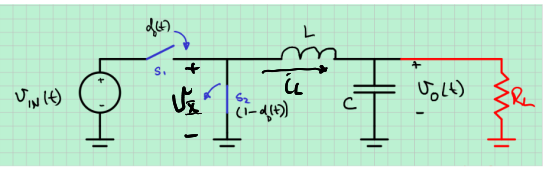

This is a state space averaged model.

To do the state space averaging, we average the two switch positions.  The top switch is down $d_D(t)$ of the time, and open $1-d_D(t)$ of the time, and exactly one switch is open or closed at the same time.  This gives 
$$v_x(t) = \begin{cases} 
      0, & d_D(t) \le 0 \\
      v_{IN}(t)d_D(t), & 0 \le d_D(t) \le 1 \\
      v_{IN}(t) & d_D(t), \ge 1 
\end{cases}
$$
We further assume $v_{IN}(t) = V_{IN}$ a constant voltage.  If we could adjust it, there would be no reason for the buck converter. We also assume $R_L$ is constant, which is more likely to be untrue, but for the testing Aaron and Kyle did it is constant.
$$L\dot {i_L}(t) = v_x(t) - v_O(t)$$
$$C \dot {v_C}(t) =i_L(t) - \frac{v_O(t)}{R_L}$$
$$\begin{bmatrix} \dot {i_L}(t) \\ \dot {v_O}(t)  \end{bmatrix} = \begin{bmatrix} 0 && \frac{-1}{L} \\ \frac{1}{C} &&\frac{-1}{R_LC}\end{bmatrix} \begin{bmatrix} {i_L(t)} \\ {v_O}(t) \end{bmatrix} + \begin{bmatrix} \frac{V_{IN}}{L} \\ 0 \end{bmatrix} d_D(t)$$
$$v_O(t) = \begin {bmatrix} 0 && 1\end{bmatrix} \begin{bmatrix} i_L(t) \\ v_O(t) \end {bmatrix}$$

Let's simulate placing the poles of this system.

There are at least four big problems.  By playing with the script below you can see that just placing the poles anywhere is likely to give you a duty cycle outside of the allowed range (0,1).  We can use the LQR algoritym to emphasize that we want low input so the duty cycle will not get so big.  This works, but another problem is that the voltage needs to be overdamped so you don't overvoltage a device connected to the power supply when it is turned on.   The poles are almost always underdamped.  Another problem is that we are assuming the converter is in continuous conduction mode (CCM).  The current often shoots down to being negative, which cannot happen in the real circuit because of the diode causes a non-linear effect which requires a different small signal model and Q point.  The last problem is that the Arduino Nano that we are using to vary the duty cycle takes a while for multiplies.  This means the sample time is not as short as we would like.  This limits poles that are far into the left half plane, because we wouldn't have enough control times per decay to control it.  The script below explores the first three effects.  The upshot of this is that we cannot really pick the eigenvalues (poles) we want arbitrarilly.  Most will result in a non-linear system which means the idea of $e^{\lambda t}$ eigenmodes are only approximate at best.  The non-linear nature of the duty cycle is really troublesome, because feedback works pretty well when you have a gain that varies, but it cannot be zero, because zero multiplied by anything is still zero, which shuts down the control loop. 

A =

            0  -1.0000e+03
   1.0000e+04  -3.8462e+02

B =

   10000
       0

C =

   0   1

R = 1.0000e+10
G =

   1.4319e-08  -5.0000e-11

eigs =

   -192.3 + 3156.4i
   -192.3 - 3156.4i


sf_sys.a =
               x1          x2
   x1  -0.0001432       -1000
   x2       1e+04      -384.6

sf_sys.b =
       u1
   x1   1
   x2   1

sf_sys.c =
       x1  x2
   y1   0   1

sf_sys.d =
       u1
   y1   0

Continuous-time model.


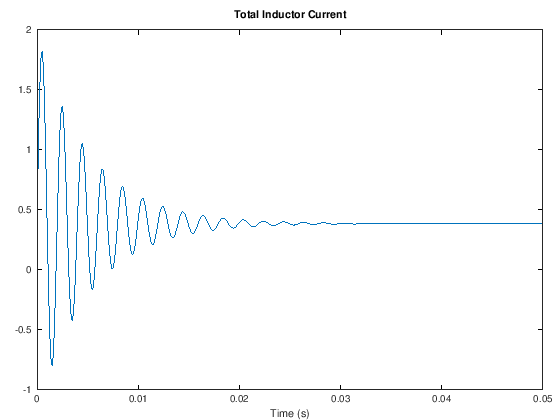

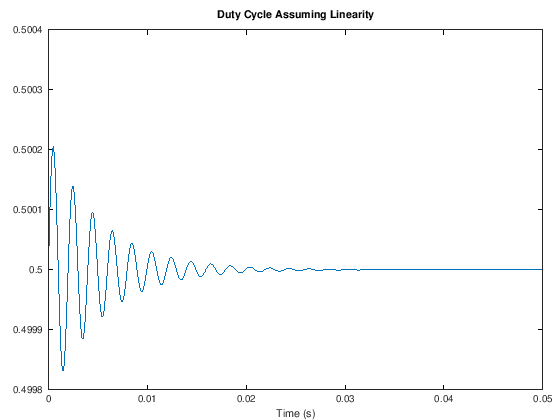

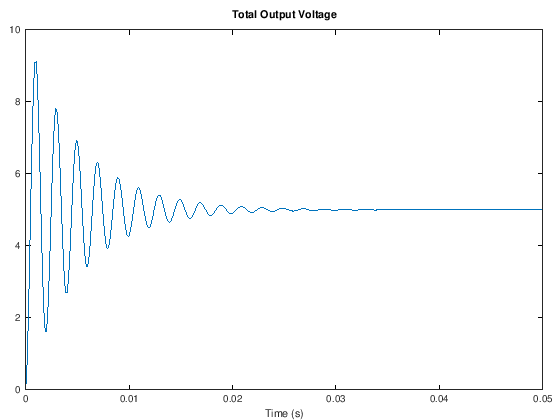

In [16]:
clear all; close all;
pkg load control;
available_graphics_toolkits();
graphics_toolkit("gnuplot")
L = 1e-3; % 1 mH
C = 100e-6; % 100 uF
RL = 26; % Ohms
VIN = 10;
Duty = 0.5;
A = [[0 -1/L];[1/C -1/(RL*C)]]
B = [VIN/L; 0]
C = [0 1]
D = 0;
sys = ss(A,B,C,D);
%poles = [-101 -100]  % What happens if you manually place poles...
%G = place(A,B,poles)
Q = [[1 0];[0 1]];
R = 10000000000
G = lqr(sys, Q, R)
eigs = eig(A-B*G)
sf_sys = ss(A-B*G, ones(size(B)),C,0)
t=0:0.0001:0.05;
%lsim(sys, zeros(size(t)), t, [0; -5]);
[y,tOut,x] = lsim(sf_sys, zeros(size(t)), t, [0; -5]);
%plot(tOut,x)
%title('States')
%legend('Inductor Current', 'Output Voltage')
x = x';
figure(1)
BGx = B*G*x;
BGx = BGx(1,:);
plot(tOut, BGx+Duty);
xlabel('Time (s)')
title('Duty Cycle Assuming Linearity')
set(gcf,'Visible','on')
figure(2)
plot(tOut, x(1,:)+VIN/RL)
title('Total Inductor Current')
xlabel('Time (s)')
set(gcf,'Visible','on')
figure(3)
plot(tOut, x(2,:)+VIN*Duty)
title('Total Output Voltage')
xlabel('Time (s)')
set(gcf,'Visible','on')

This results above shows we need to do a non-linear simulation to see what really happens when we use this feedback.  We won't get the pole locations we want, but at least we might be able to see what we get.  In general we need to change the pole locations in a way to keep the duty cycle between zero and one.  The code below simulates what happens due to the duty cycle clipping, but does not incorporate discontinuous conduction mode (DCM).  If the current goes negative, then the results are wrong.

ans = -110.68


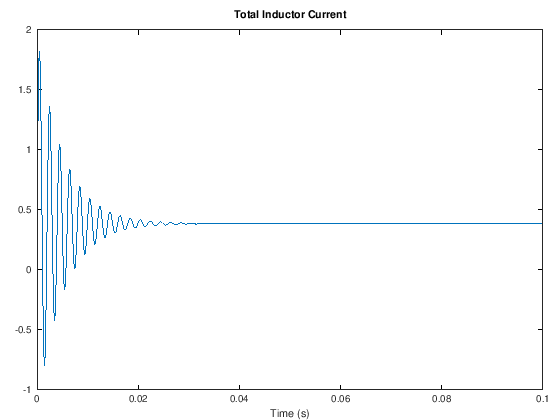

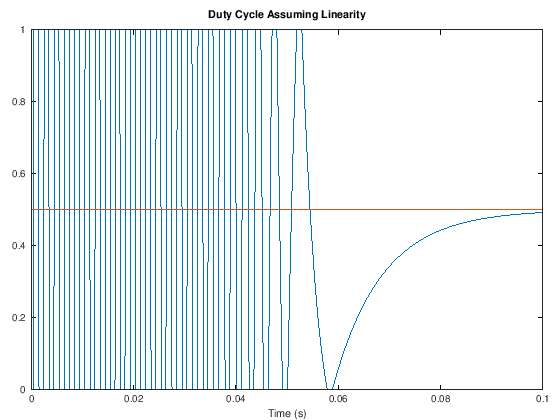

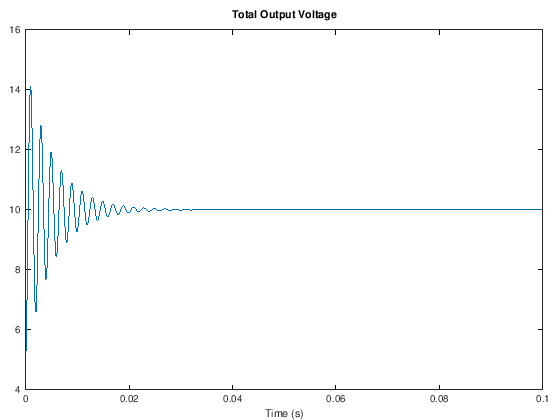

In [19]:
% sim_buck_nonlinear.m
pkg load control
  pkg load miscellaneous % for the clip() function
function [t, x] = sim_buck_nonlinear
    Trun = .1;
    T = 1/10000;
    t = 0:T:Trun;
    [t, x] = ode45(@rhs, t, [0; -5]);
    plot(t, x)
    legend('\i_L', '\v_O')
    title('Buck Converter CCM With 0<d<1')
endfunction
function dxdt = rhs(t, x)
  L = 1e-3; % 1 mH
  C = 100e-6; % 100 uF
  RL = 26; % Ohms
  VIN = 10;
  Duty = 0.5;
  A = [[0 -1/L];[1/C -1/(RL*C)]];
  B = [VIN/L; 0];
  poles = [-200 -100];
  G = place(A,B,poles);
  dxdt = (A*x-clip(B*G*x, [-.5, .5]));
endfunction


[tOut, x] = sim_buck_nonlinear;
L = 1e-3; % 1 mH
C = 100e-6; % 100 uF
RL = 26; % Ohms
VIN = 10;
Duty = 0.5;
A = [[0 -1/L];[1/C -1/(RL*C)]];
B = [VIN/L; 0];
poles = [-200 -100];
G = place(A,B,poles);
x = x';
figure(1)
BGx = B*G*x;
BGx = -clip(B*G*x, [-.5, .5]);
plot(tOut, BGx+Duty);
xlabel('Time (s)')
title('Duty Cycle Assuming Linearity')
set(gcf,'Visible','on')
figure(2)
plot(tOut, x(1,:)+VIN/RL)
title('Total Inductor Current')
xlabel('Time (s)')
set(gcf,'Visible','on')
figure(3)
plot(tOut, x(2,:)+VIN)
title('Total Output Voltage')
xlabel('Time (s)')
set(gcf,'Visible','on')

Note that at least with these poles, the current is in DCM, so the model is not right. The output is still underdamped, but the diode will help us in this case, because it will choke all those negative currents that cause the oscillation.  My hope is that if we incorporated DCM into the model, it would at least match the real world.  The best thing to do is to tweak the actual device until you like the response (sad).  :-) 

Aaron Sturtevant's measurements indicate that the Thevenin resistance of the source has significant effect on the system.  For this reason it would be good to develop a third order model that incorperates the input capacitance and the Thevenin resistance of the source.  
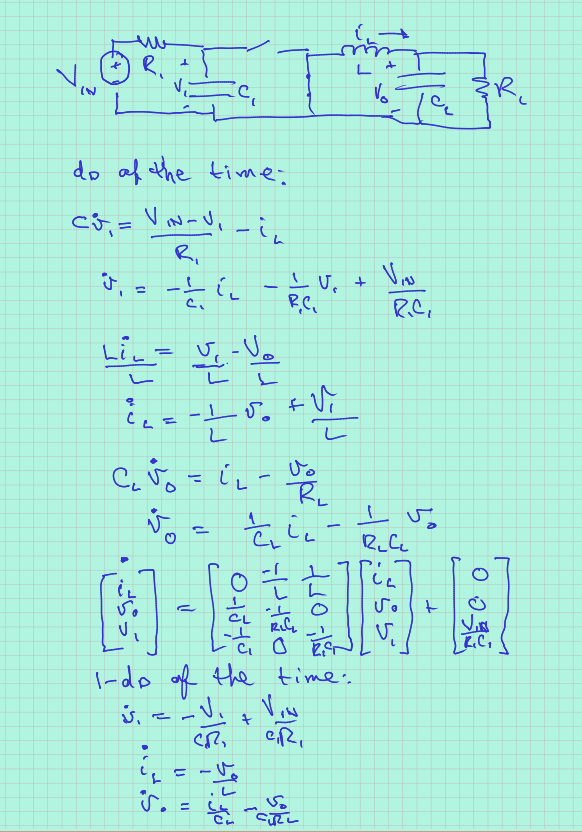
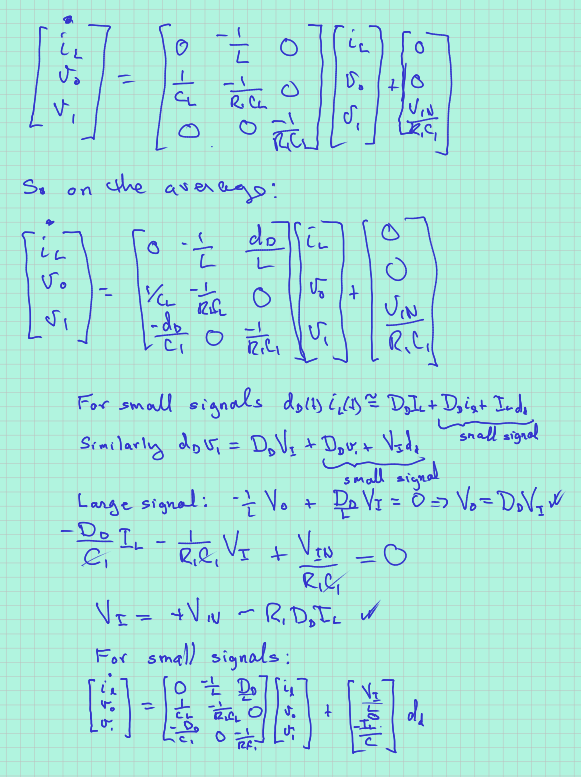
The next step is to implement this in octave.